This is Week 5 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python. It will helpful for me to do these exercises myself, but that repo will serve as a helpful reference.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

# Question 1 (8H5)

Consider the data(Wines2012) data table. These data are expert ratings
of 20 different French and American wines by 9 different French and American
judges. Your goal is to model score, the subjective rating assigned by
each judge to each wine. I recommend standardizing it.
In this first problem, consider only variation among judges and wines.
Construct index variables of judge and wine and then use these index variables
to construct a linear regression model. Justify your priors. You should
end up with 9 judge parameters and 20 wine parameters. Use ulam instead
of quap to build this model, and be sure to check the chains for convergence.
If you’d rather build the model directly in Stan or PyMC3 or Julia (Turing is
a good choice!), go ahead. I just want you to use MCMC instead of quadratic
approximation.
How do you interpret the variation among individual judges and individual
wines? Do you notice any patterns, just by plotting the differences?
Which judges gave the highest/lowest ratings? Which wines were rated worst/
best on average?

In [4]:
os.getcwd()

'/Users/blacar/Documents/ds_projects/stats_rethinking/repo'

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [6]:
df_wines = pd.read_csv("other_data/Wines2012.csv")
df_wines["score_std"] = standardize(df_wines["score"])
df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.581002
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.451715
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075286
3,Jean-M Cardebat,white,D1,15.0,0,0,0.301143
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.333860


<IPython.core.display.Javascript object>

In [7]:
df_wines["judge"].unique()

array(['Jean-M Cardebat', 'Tyler Colman', 'John Foy', 'Olivier Gergaud',
       'Robert Hodgson', 'Linda Murphy', 'Daniele Meulder',
       'Jamal Rayyis', 'Francis Schott'], dtype=object)

<IPython.core.display.Javascript object>

In [8]:
df_wines["wine"].unique()

array(['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'A2',
       'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2'], dtype=object)

<IPython.core.display.Javascript object>

## My approach

- Create index variables for `judge` and `wine`.
- Create a linear model that uses these index variables only.
- Inspect the summary.

## Create index variables

### Manual method

In [9]:
judge_dict = dict()
count = 0
for judge in sorted(df_wines["judge"].unique()):
    judge_dict[judge] = count
    count += 1

<IPython.core.display.Javascript object>

In [10]:
wine_dict = dict()
count = 0
for wine in sorted(df_wines["wine"].unique()):
    wine_dict[wine] = count
    count += 1

<IPython.core.display.Javascript object>

In [11]:
df_wines["judge_index"] = df_wines["judge"].copy().replace(judge_dict)
df_wines["wine_index"] = df_wines["wine"].copy().replace(wine_dict)

<IPython.core.display.Javascript object>

In [12]:
df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std,judge_index,wine_index
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.581002,3,0
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.451715,3,2
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075286,3,4
3,Jean-M Cardebat,white,D1,15.0,0,0,0.301143,3,6
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.333860,3,8


<IPython.core.display.Javascript object>

### Using `pm.Categorical`

In [13]:
df_wines["judge_index"] = pd.Categorical(df_wines["judge"]).codes
df_wines["wine_index"] = pd.Categorical(df_wines["wine"]).codes

df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std,judge_index,wine_index
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.581002,3,0
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.451715,3,2
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075286,3,4
3,Jean-M Cardebat,white,D1,15.0,0,0,0.301143,3,6
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.333860,3,8


<IPython.core.display.Javascript object>

## Create a linear model that uses these judge, wine index variables

Even though judge and wine are both categorical variables, the model is built similarly, using index notation. The score is standardized in this case.


\(\text{score}_i$ ~ Normal($\mu_i, \sigma\))
<br>
\(\mu_i = judge_i[i] + wine_i[j]\)
<br>
\(judge\) ~ \(\text{Normal}(0, 2)\)
<br>
\(wine\) ~ \(\text{Normal}(0, 2)\)
<br>
\(\sigma\) ~ \(\text{Exp}(1)\)

To create the model with two categorical variables and using the index variable approach, I referenced page 158, R code 5.54 and also the [chapter 5 pymc repo](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_05.ipynb) which is shown below.

```
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=d["house"].max() + 1)
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=d["clade_id"].max() + 1)
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])
```

I was curious about the shape parameter and found [this discussion](https://discourse.pymc.io/t/pm-normal-what-is-the-shape-parameter-for-a-normal-distribution/1851). It is basically the number of unique values for that category.

In [21]:
with pm.Model() as wine_model:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Fitting and sampling all at once.
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wine, judge]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [22]:
az.summary(trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
judge[0],-0.338,0.416,-1.022,0.303,0.024,0.017,293.0,293.0,296.0,644.0,1.02
judge[1],0.215,0.419,-0.442,0.881,0.026,0.018,260.0,260.0,259.0,699.0,1.02
judge[2],0.205,0.418,-0.494,0.835,0.023,0.017,319.0,319.0,319.0,715.0,1.02
judge[3],-0.641,0.417,-1.279,0.050,0.026,0.018,255.0,255.0,255.0,649.0,1.02
judge[4],0.873,0.418,0.192,1.514,0.025,0.018,270.0,270.0,269.0,619.0,1.02
judge[5],0.512,0.421,-0.118,1.234,0.024,0.017,299.0,299.0,300.0,630.0,1.02
judge[6],0.125,0.423,-0.538,0.788,0.026,0.018,265.0,265.0,264.0,550.0,1.02
judge[7],-0.770,0.420,-1.413,-0.085,0.025,0.018,276.0,276.0,276.0,591.0,1.02
judge[8],-0.418,0.418,-1.080,0.235,0.025,0.018,273.0,273.0,270.0,651.0,1.02
wine[0],0.173,0.463,-0.559,0.908,0.025,0.018,332.0,332.0,331.0,1003.0,1.01


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

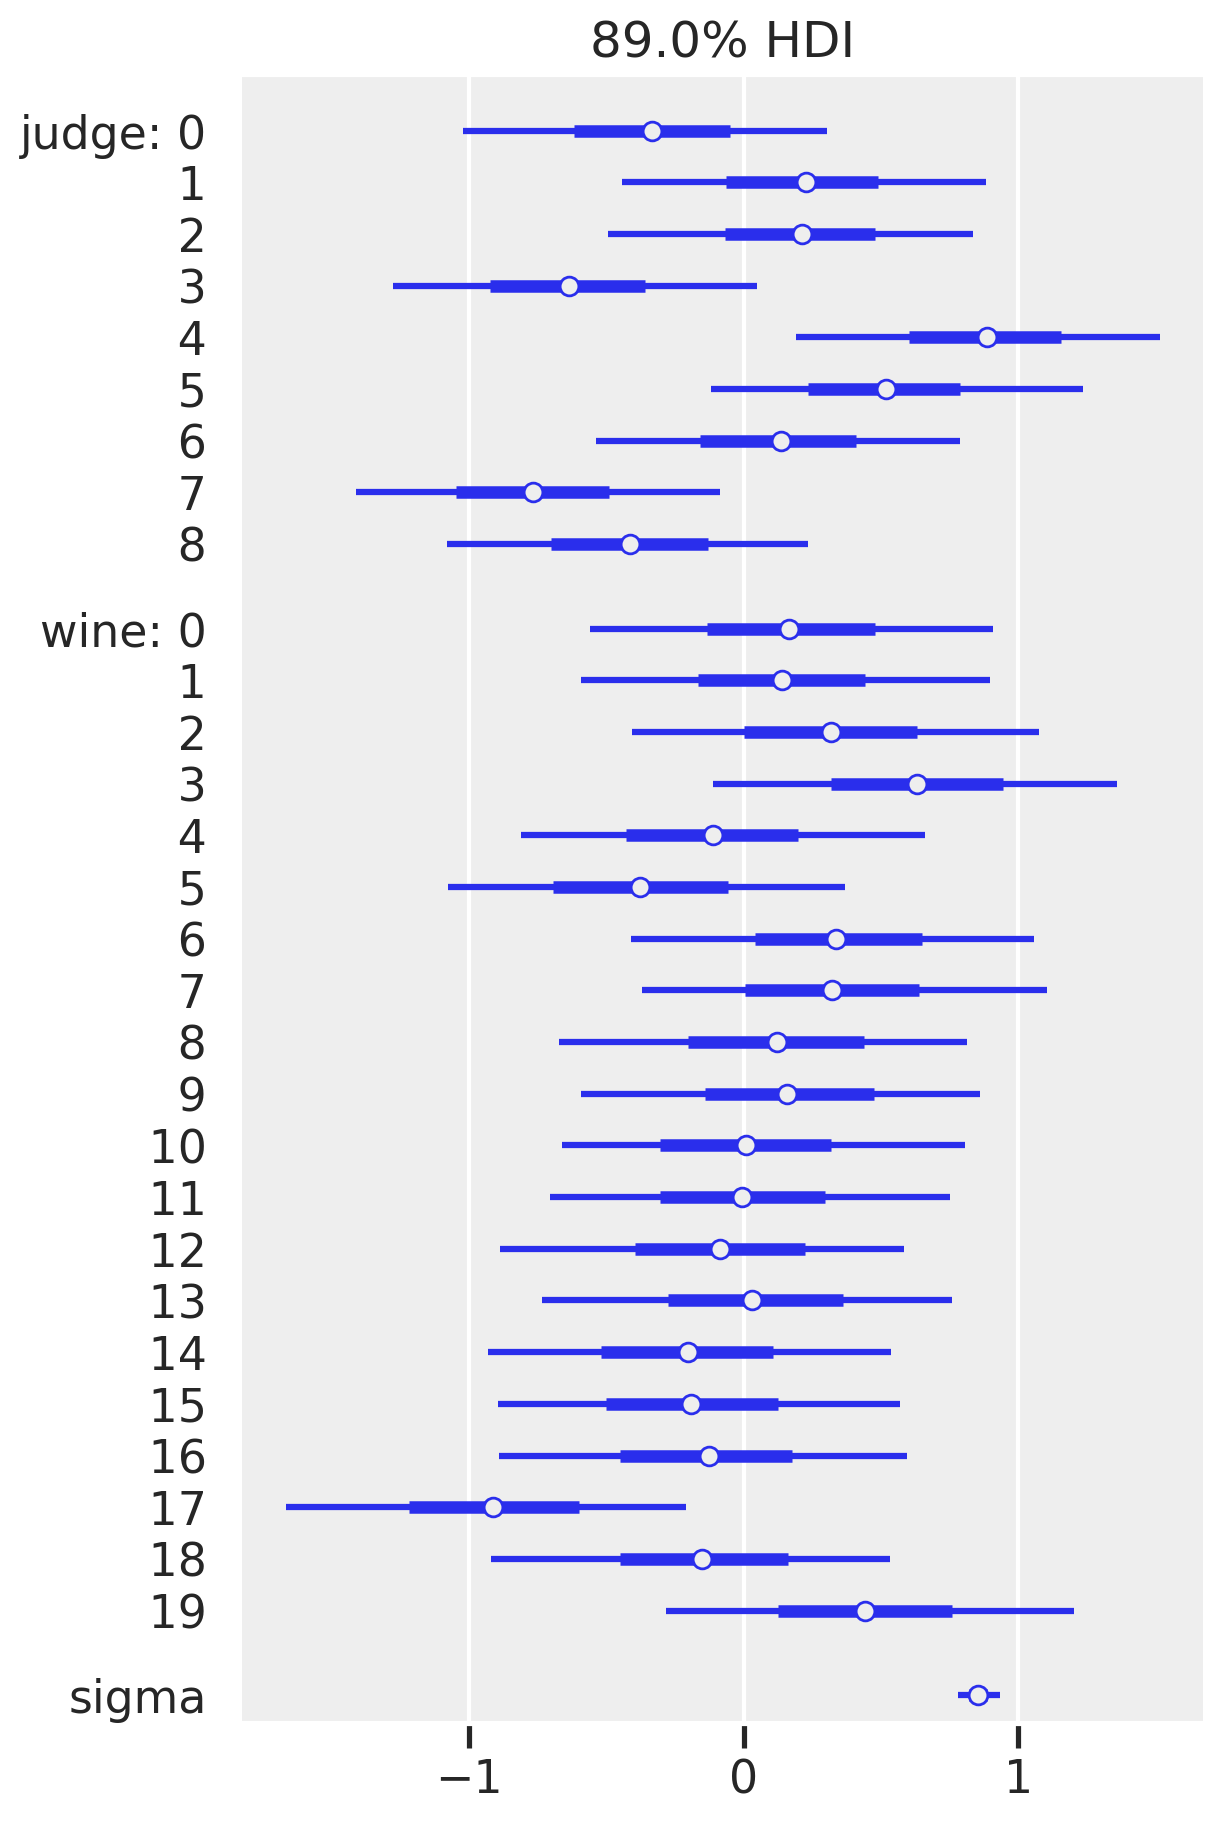

<IPython.core.display.Javascript object>

In [23]:
az.plot_forest(trace, combined=True)

### Assess patterns

**Which judges gave the highest/lowest ratings?**

In [30]:
az.summary(trace)[az.summary(trace).index.str.contains("judge")].sort_values(
    by="mean", ascending=False
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
judge[4],0.873,0.418,0.192,1.514,0.025,0.018,270.0,270.0,269.0,619.0,1.02
judge[5],0.512,0.421,-0.118,1.234,0.024,0.017,299.0,299.0,300.0,630.0,1.02
judge[1],0.215,0.419,-0.442,0.881,0.026,0.018,260.0,260.0,259.0,699.0,1.02
judge[2],0.205,0.418,-0.494,0.835,0.023,0.017,319.0,319.0,319.0,715.0,1.02
judge[6],0.125,0.423,-0.538,0.788,0.026,0.018,265.0,265.0,264.0,550.0,1.02
judge[0],-0.338,0.416,-1.022,0.303,0.024,0.017,293.0,293.0,296.0,644.0,1.02
judge[8],-0.418,0.418,-1.080,0.235,0.025,0.018,273.0,273.0,270.0,651.0,1.02
judge[3],-0.641,0.417,-1.279,0.050,0.026,0.018,255.0,255.0,255.0,649.0,1.02
judge[7],-0.770,0.420,-1.413,-0.085,0.025,0.018,276.0,276.0,276.0,591.0,1.02


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

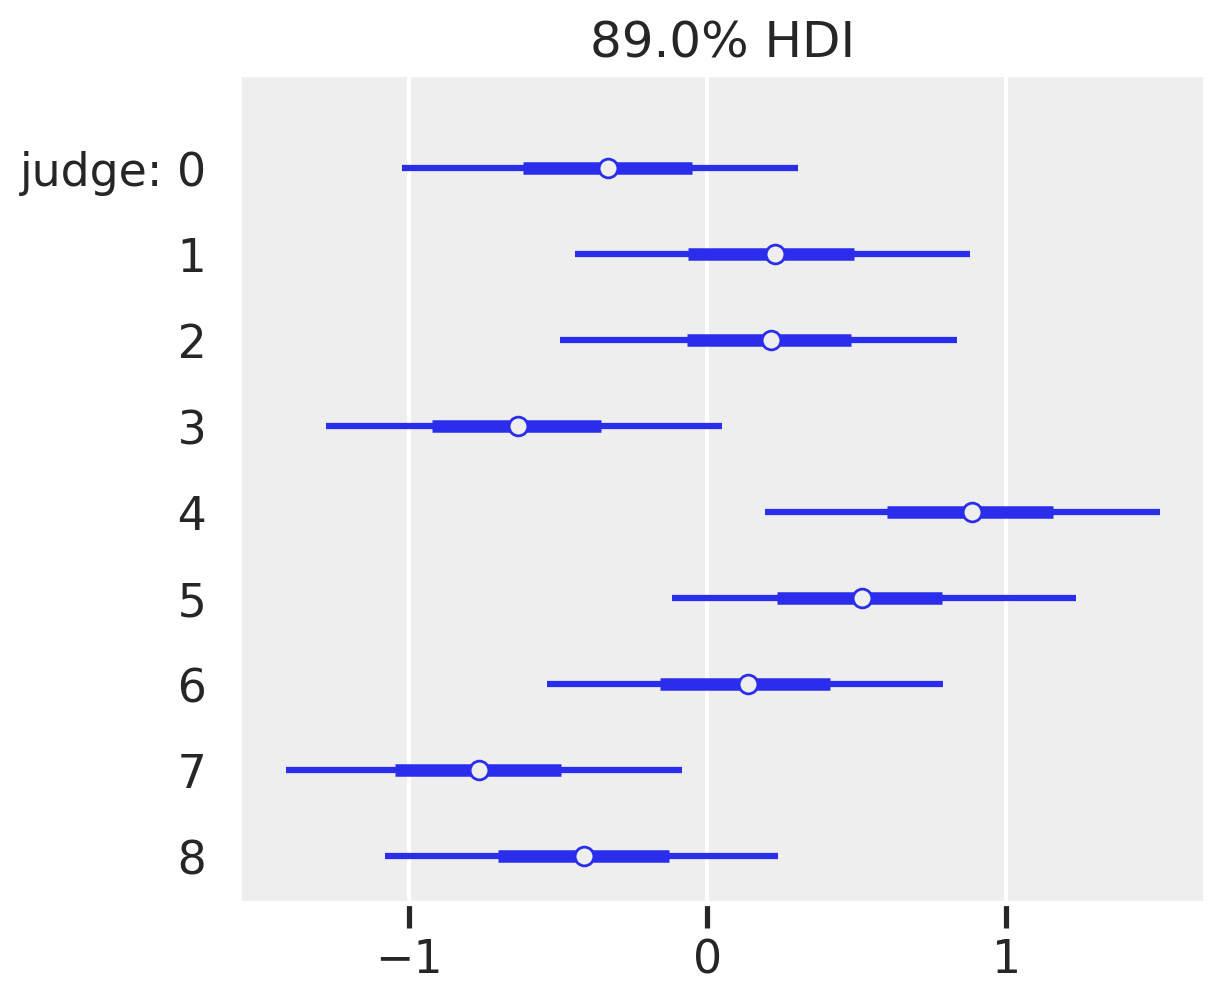

<IPython.core.display.Javascript object>

In [35]:
az.plot_forest(data=trace, var_names="judge", combined=True)

**Which wines were rated worst/best on average?**

In [37]:
az.summary(trace)[az.summary(trace).index.str.contains("wine")].sort_values(
    by="mean", ascending=False
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
wine[3],0.632,0.469,-0.113,1.357,0.024,0.017,370.0,370.0,370.0,919.0,1.01
wine[19],0.447,0.468,-0.284,1.201,0.025,0.018,343.0,343.0,343.0,791.0,1.01
wine[6],0.347,0.464,-0.409,1.059,0.023,0.016,404.0,404.0,399.0,874.0,1.01
wine[7],0.322,0.468,-0.371,1.105,0.023,0.016,410.0,410.0,412.0,893.0,1.01
wine[2],0.317,0.465,-0.407,1.074,0.023,0.016,405.0,405.0,406.0,857.0,1.01
wine[0],0.173,0.463,-0.559,0.908,0.025,0.018,332.0,332.0,331.0,1003.0,1.01
wine[9],0.164,0.458,-0.593,0.861,0.025,0.018,324.0,324.0,321.0,775.0,1.01
wine[1],0.139,0.466,-0.593,0.898,0.022,0.016,449.0,449.0,447.0,873.0,1.01
wine[8],0.119,0.468,-0.673,0.814,0.024,0.017,378.0,378.0,376.0,737.0,1.01
wine[13],0.034,0.467,-0.735,0.759,0.022,0.016,453.0,453.0,449.0,834.0,1.01


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

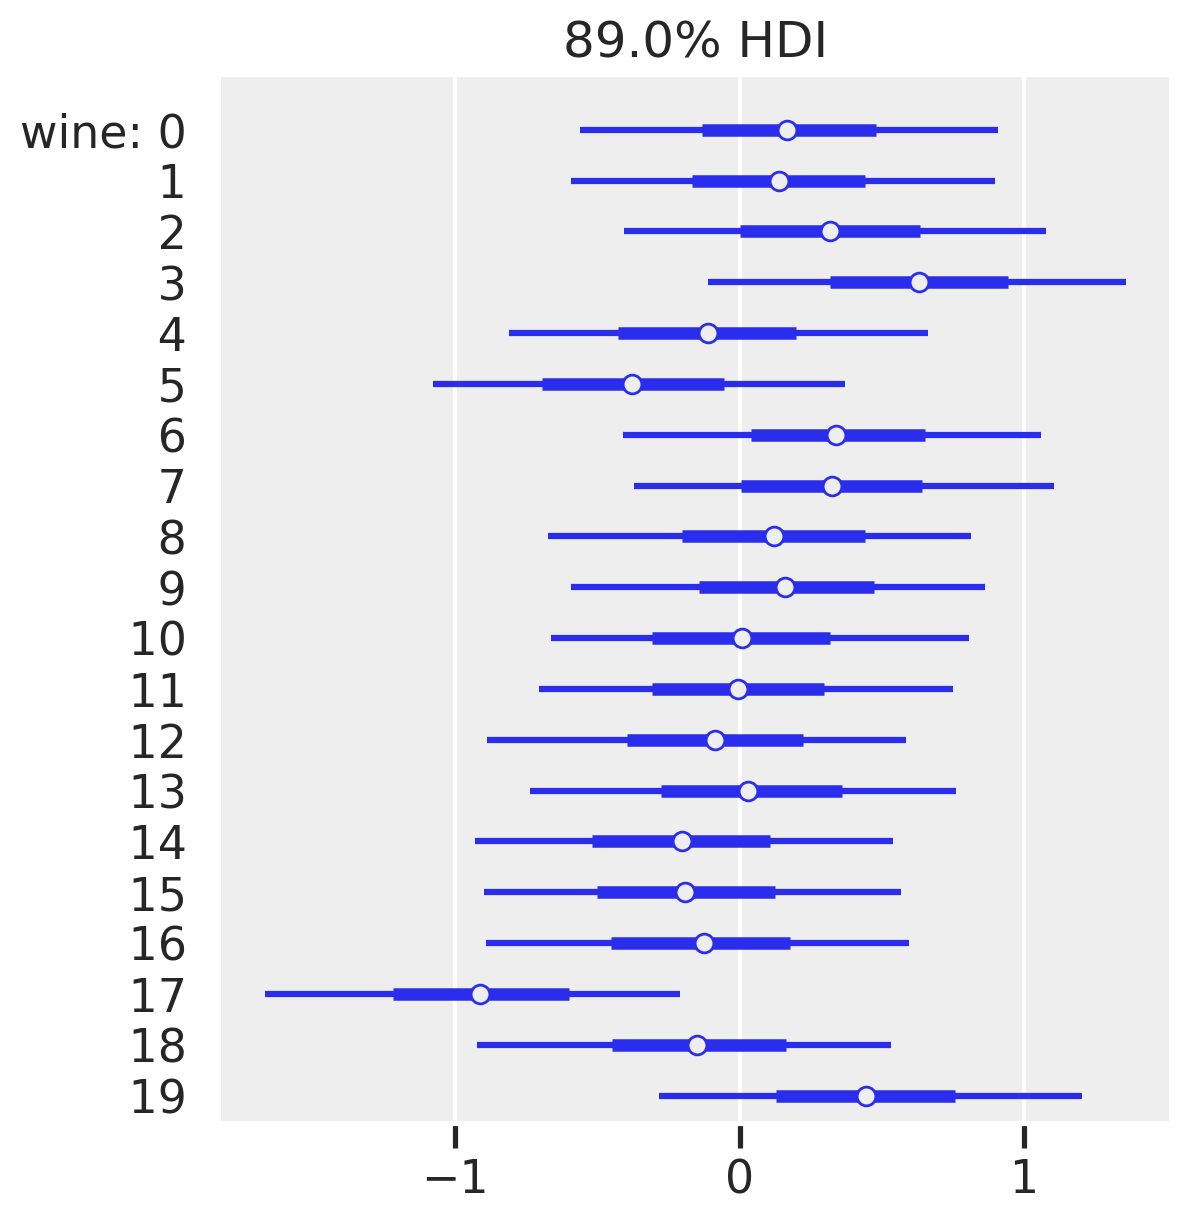

<IPython.core.display.Javascript object>

In [36]:
az.plot_forest(data=trace, var_names="wine", combined=True)

# Question 2 (8H6)

Now consider three features of the wines and judges:
(1) flight: Whether the wine is red or white.
(2) wine.amer: Indicator variable for American wines.
(3) judge.amer: Indicator variable for American judges.
Use indicator or index variables to model the influence of these features on
the scores. Omit the individual judge and wine index variables from Problem 1. Do not include interaction effects yet. Again use ulam, justify your priors,
and be sure to check the chains. What do you conclude about the differences
among the wines and judges? Try to relate the results to the inferences in
Problem 1.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


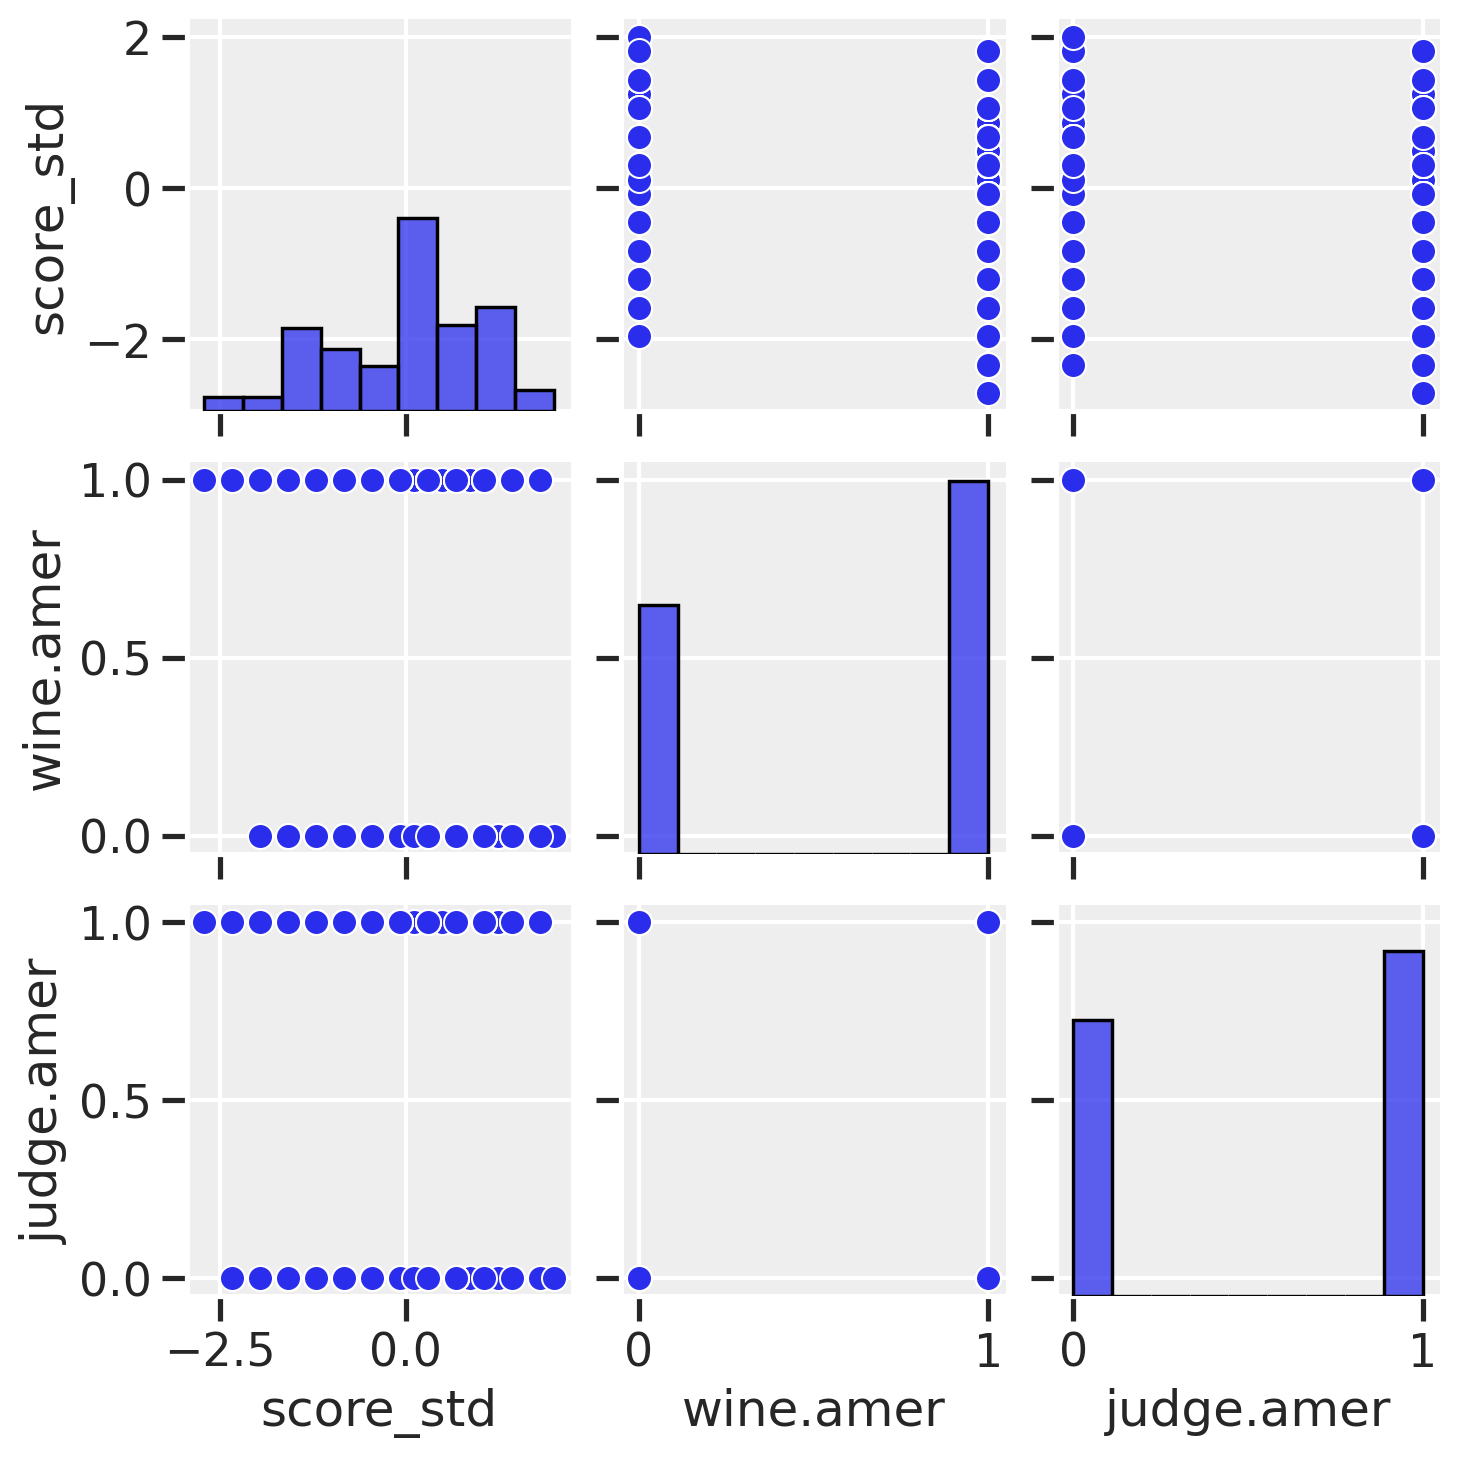

<IPython.core.display.Javascript object>

In [43]:
sns.pairplot(df_wines[["score_std", "wine.amer", "judge.amer"]])

# Question 3 (8H70

Now consider two-way interactions among the three features. You should
end up with three different interaction terms in your model. These will be
easier to build, if you use indicator variables. Again use ulam, justify your
priors, and be sure to check the chains. Explain what each interaction means.
Be sure to interpret the model’s predictions on the outcome scale (mu, the
expected score), not on the scale of individual parameters. You can use link
to help with this, or just use your knowledge of the linear model instead.
What do you conclude about the features and the scores? Can you relate
the results of your model(s) to the individual judge and wine inferences from
Problem 1?

Appendix: Environment and system parameters

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed May 26 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
pandas    : 1.2.1
arviz     : 0.11.1
json      : 2.0.9
matplotlib: 3.3.4
pymc3     : 3.11.0
seaborn   : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>